In [3]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTETomek 
import matplotlib.pyplot as plt


In [4]:
def check_data_leakage(X_train, X_valid, X_test):
    train_df = pd.DataFrame(X_train)
    valid_df = pd.DataFrame(X_valid)
    test_df = pd.DataFrame(X_test)

    overlap_train_test = test_df.merge(train_df, how="inner")
    overlap_train_valid = test_df.merge(valid_df, how="inner")

    print(f"Overlapping samples between Train & Test: {len(overlap_train_test)}")
    print(f"Overlapping samples between Validation & Test: {len(overlap_train_valid)}")

In [5]:

def add_noise(X_train, mean=0, sigma=0.1):
    """
    Adds Gaussian noise to the training data.
    Args:
        X_train (numpy array): Training features.
        mean (float): Mean of Gaussian noise.
        sigma (float): Standard deviation of noise.

    Returns:
        numpy array: Noisy training features.
    """
    noise = np.random.normal(mean, sigma, X_train.shape)
    return X_train + noise

In [8]:
# Load dataset from CSV
df = pd.read_csv("./creditcard.csv")

# Standardize features first
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original Time and Amount columns
df.drop(['Time','Amount'], axis=1, inplace=True)

# Extract features & labels after scaling is done
X = df.drop(columns=['Class']).values
y = df['Class'].values

In [9]:

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y.tolist())
class_weights = torch.tensor(class_weights, dtype=torch.float32)  # Convert to PyTorch tensor

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
print("Applying SMOTE to balance training data...")
smote = SMOTETomek(sampling_strategy=0.4, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Applying SMOTE to balance training data...


In [11]:
print("Dataset Distribution:")
print(f"Total samples: {len(y)}")
print(f"Class 0 (Non-Fraud): {np.sum(y == 0)} samples ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Class 1 (Fraud): {np.sum(y == 1)} samples ({np.sum(y == 1)/len(y)*100:.2f}%)")
print("\nTrain-Test Split:")
print(f"Training set: {len(y_train)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_train == 0)} samples ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_train == 1)} samples ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"Test set: {len(y_test)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_test == 0)} samples ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_test == 1)} samples ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")

Dataset Distribution:
Total samples: 284807
Class 0 (Non-Fraud): 284315 samples (99.83%)
Class 1 (Fraud): 492 samples (0.17%)

Train-Test Split:
Training set: 318431 samples
  - Class 0 (Non-Fraud): 227451 samples (71.43%)
  - Class 1 (Fraud): 90980 samples (28.57%)
Test set: 56962 samples
  - Class 0 (Non-Fraud): 56864 samples (99.83%)
  - Class 1 (Fraud): 98 samples (0.17%)


In [12]:
noise_std = 0.1  # You can adjust this parameter
X_train = add_noise(X_train, sigma=noise_std)  # Add noise

In [13]:
# Print post-noise training data stats
print("\nTraining Data (After Noise):")
print(f"Training set: {len(y_train)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_train == 0)} samples ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_train == 1)} samples ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"  - Feature statistics: Mean={X_train.mean():.4f}, Std={X_train.std():.4f}")

# Print test data stats
print("\nTest Data:")
print(f"Test set: {len(y_test)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_test == 0)} samples ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_test == 1)} samples ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")
print(f"  - Feature statistics: Mean={X_test.mean():.4f}, Std={X_test.std():.4f}")


Training Data (After Noise):
Training set: 318431 samples
  - Class 0 (Non-Fraud): 227451 samples (71.43%)
  - Class 1 (Fraud): 90980 samples (28.57%)
  - Feature statistics: Mean=-0.3963, Std=2.8100

Test Data:
Test set: 56962 samples
  - Class 0 (Non-Fraud): 56864 samples (99.83%)
  - Class 1 (Fraud): 98 samples (0.17%)
  - Feature statistics: Mean=-0.0001, Std=1.0475


In [14]:
validation_fraction = 0.2  # You can adjust this parameter
if validation_fraction > 0:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=validation_fraction, stratify=y_train, random_state=42
    )
else:
    X_valid, y_valid = None, None  # Assign None to avoid UnboundLocalError

In [15]:
if X_valid is not None and X_test is not None:
    print("\nChecking for data leakage...")
    check_data_leakage(X_train, X_valid, X_test)


Checking for data leakage...
Overlapping samples between Train & Test: 0
Overlapping samples between Validation & Test: 0


In [28]:
print("\nFinal Dataset Distributions:")
print(f"Original dataset: {len(y)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y == 0)} samples ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y == 1)} samples ({np.sum(y == 1)/len(y)*100:.2f}%)")

print(f"\nTraining set: {len(y_train)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_train == 0)} samples ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_train == 1)} samples ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")

if X_valid is not None:
    print(f"\nValidation set: {len(y_valid)} samples")
    print(f"  - Class 0 (Non-Fraud): {np.sum(y_valid == 0)} samples ({np.sum(y_valid == 0)/len(y_valid)*100:.2f}%)")
    print(f"  - Class 1 (Fraud): {np.sum(y_valid == 1)} samples ({np.sum(y_valid == 1)/len(y_valid)*100:.2f}%)")

print(f"\nTest set: {len(y_test)} samples")
print(f"  - Class 0 (Non-Fraud): {np.sum(y_test == 0)} samples ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  - Class 1 (Fraud): {np.sum(y_test == 1)} samples ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")


Final Dataset Distributions:
Original dataset: 284807 samples
  - Class 0 (Non-Fraud): 284315 samples (99.83%)
  - Class 1 (Fraud): 492 samples (0.17%)

Training set: 254744 samples
  - Class 0 (Non-Fraud): 181960 samples (71.43%)
  - Class 1 (Fraud): 72784 samples (28.57%)

Validation set: 63687 samples
  - Class 0 (Non-Fraud): 45491 samples (71.43%)
  - Class 1 (Fraud): 18196 samples (28.57%)

Test set: 56962 samples
  - Class 0 (Non-Fraud): 56864 samples (99.83%)
  - Class 1 (Fraud): 98 samples (0.17%)


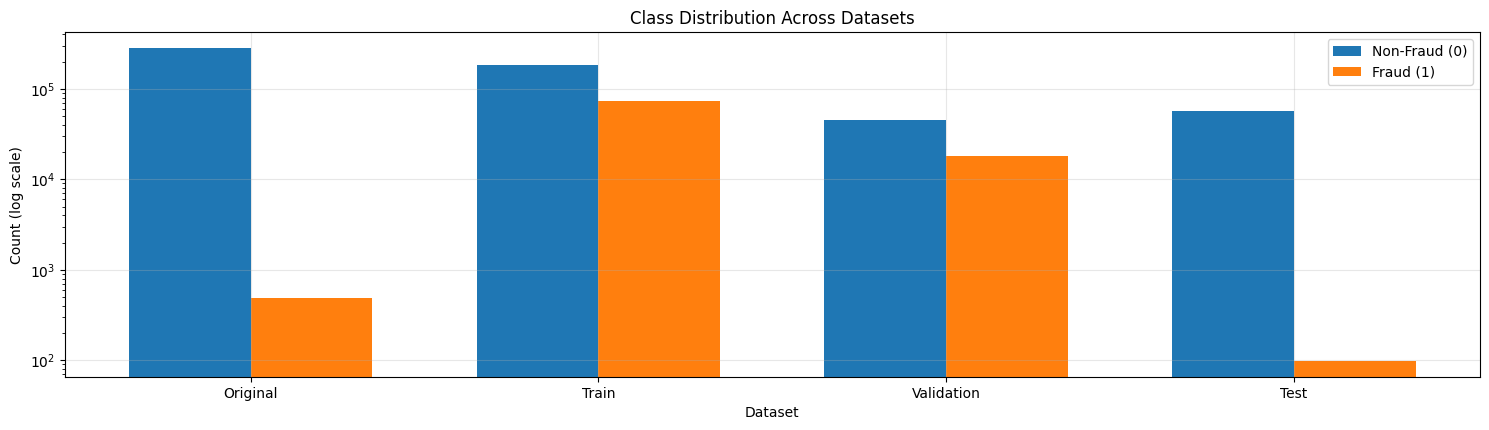

In [16]:
plt.figure(figsize=(15, 8))

# Plot 1: Count distribution
plt.subplot(2, 1, 1)
datasets = ['Original', 'Train', 'Validation', 'Test']
non_fraud_counts = [np.sum(y == 0), np.sum(y_train == 0), np.sum(y_valid == 0), np.sum(y_test == 0)]
fraud_counts = [np.sum(y == 1), np.sum(y_train == 1), np.sum(y_valid == 1), np.sum(y_test == 1)]

x = np.arange(len(datasets))
width = 0.35

plt.bar(x - width/2, non_fraud_counts, width, label='Non-Fraud (0)')
plt.bar(x + width/2, fraud_counts, width, label='Fraud (1)')
plt.yscale('log')
plt.xlabel('Dataset')
plt.ylabel('Count (log scale)')
plt.title('Class Distribution Across Datasets')
plt.xticks(x, datasets)
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [28]:
CHECK_IDX = 18
print(X_test[CHECK_IDX])
print(len(X_test[CHECK_IDX]))

[-0.91346768 -0.52573506  0.73337331 -0.70805609  2.15383896  3.70395211
 -0.80050378  1.04717341 -1.72492933  0.51297295 -0.52212028 -0.65596014
  0.40108814  0.07197799  1.50583217 -1.10712744 -0.54827227  2.28239781
 -0.13078754  0.07643861 -0.15405371 -0.39784001 -0.0361439   0.95606445
  0.42833208 -0.15240036  0.08711025  0.10140009 -0.07736145 -0.41593315]
30


In [29]:
print(X_train[CHECK_IDX])
print(len(X_train[CHECK_IDX]))

[-3.17990934  3.06840107 -5.45571397  2.53525895 -1.46644623 -2.15766651
 -3.61783441  0.40899829 -0.14010881 -5.50717861  5.40408725 -8.64567989
  0.94900324 -8.18088724  0.03131969 -4.22980763 -6.31654715 -1.59485217
  0.20474783 -0.08988478  1.06509165 -0.13040026  0.26004062  0.41668331
 -0.17078057  0.01633849 -0.47410678  0.93726424 -0.28754434 -0.71657769]
30


In [30]:
print(X_valid[CHECK_IDX])
print(len(X_valid[CHECK_IDX]))

[ 1.88637051 -0.38243772 -0.36067728  1.16071736 -0.41896507  0.01207451
 -0.82956814  0.15285289  0.90534831  0.36170781  0.32080932 -0.07836471
 -1.68557869  0.4831181   0.04912577  0.90571311 -1.03152015  0.69548342
  0.02141679 -0.27366116 -0.08764279 -0.53360159  0.41497404 -0.65017173
 -0.14602202 -0.90080507  0.14657598  0.01995263 -0.46057737  0.39866155]
30
